### Análisis Realizado

Al analizar los documentos, se buscan responder las siguientes preguntas:

1) <b> ¿Cuales son los temas mas relevantes que se expusieron en los medios duante 2017 sobre la temática violencia? </b>

2) <b> ¿De qué temas relacionados a la violencia hablan los 5 medios con más noticias en Chile? </b>

Para esto, se realiza el siguiente analisis:

1) Se analizan distribuciones por fecha de noticias y por cantidad de noticias por cada medio, con la intención de encontrar los 5 medios con más noticias.

2) Se implementa modelo de clustering K-means, analizando los tópicos encontrados.

3) Se implementa modelo LDA utilizando Gibbs Sampling, analizando los tópicos encontrados.

4) Se implementa modelo LDA utilizando Inferencia Bayesiana, analizando los tópicos encontrados.

5) Tomando como modelo el LDA Bayesiano, se responden preguntas de investigación planteadas:

    a) Se identifican tópicos identificados en los documentos para el año 2017.
    b) Se identifica la distribución de tópicos para cada uno de los 5 medios escogidos, analizando su distribución.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
#%matplotlib notebook


### Importar datos

In [2]:
# Get data

# Import data

# file name
file = 'MAD_violencia1.csv'

# load data
df = pd.read_csv(file, sep = '|', error_bad_lines = False, header = None)

# Parse to datetime format
df[0] = pd.to_datetime(df[0])

display(df.head())

# Get date and news text
news = df[[0,1,3]]

# Shape of dataframe
display('Total news: ' + str(news.shape[0]))

# Columns
news.columns = ['date', 'company', 'news']

# text
# news = news[0:100]
n = 10
news = news.sample(n)

news.head()

,0,1,2,3
0,2017-05-23 10:40:09,lacuarta,¡Sea solidario y póngase con las mamitas de C...,Esto te interesa... 22/05/2017 - Autor: La Cu...
1,2017-05-18 12:59:58,RadioValparaiso,Radio Valparaíso PDI DETIENE A AUTOR DE ROBO ...,Portada » CIUDADES » Valparaíso » PDI DETIENE...
2,2017-06-01 22:40:30,araucanianews,SOFO y SNA cuestionaron cuenta pública de Bac...,"Jueves, 1 Junio, 2017 a las 22:39 Editor Actu..."
3,2017-06-01 08:20:07,chilevision,Detuvieron a hombre que intentó asesinar a su...,La Policía de Investigaciones detuvo a un hom...
4,2017-06-01 19:10:00,PublimetroChile,Feminicidio en Argentina: mujeres se desnudan...,La Fuerza Artística de Choque Comunicativo or...


'Total news: 4468'

,date,company,news
1042,2017-05-29 15:57:43,rsumen,Por equipo Cerro a la Izquierda En el capítul...
1115,2017-06-15 13:30:16,eltipografo,Ya habían hecho sentir su descontento en ...
2449,2018-01-25 08:42:10,msncl,"La fiscal adjunta María José Sánchez, de la f..."
621,2017-08-17 18:24:36,msncl,El atentado terrorista ocurrido en La Rambla ...
637,2017-09-15 09:21:19,laopinon,El hecho ocurrió durante la noche de este jue...


### Analizado data por fecha y por medio

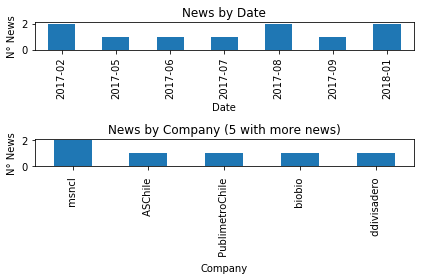

In [3]:
# Analize news by date
news_grouped_by_month = news.groupby(news.date.dt.to_period("M")).count()
news_per_month = news_grouped_by_month.news

#display(news_per_month)
fig1, axes = plt.subplots(2,1)

ax1 = news_per_month.plot.bar(ax = axes[0], x = 'date', y = 'news')
ax1.set_xlabel("Date")
ax1.set_ylabel('N° News')
ax1.title.set_text('News by Date')
plt.tight_layout()

# Analize news by company
news_grouped_by_company = news.groupby(news.company).count()
#print(news_grouped_by_company.sort(['news']))

# Sort by number of news
news_grouped_by_company.sort_values(['date'], ascending=False, inplace = True)

top_companies = 5

news_per_company = news_grouped_by_company.news[0:top_companies]

top_20_companies = news_per_company.index

ax2 = news_per_company.plot.bar(ax = axes[1], x = 'company', y = 'News')
ax2.set_xlabel("Company")
ax2.set_ylabel('N° News')
ax2.title.set_text('News by Company (5 with more news)')
plt.tight_layout()

Del gráfico de noticias en función de la fecha, se tiene que para Julio existe un máximo número de noticias (Otra posible arista de exploración es analizar que sucede en esa fecha, probablemente haya ocurrido algún evento mediático).

Del gráfico de las noticias en función de la compañia, se tiene que el medio Bío Bío es quien posee más número de noticias de violencia comparado con los demás medios. De hecho desde ADN Radio, los medios poseen número de noticias similares.

### Tokenizer

In [4]:
# Tokenizador

# Define own tokenizer
#import spacy

nlp = spacy.load('es_core_news_sm')

def own_tokenizer(sentence):
    
    tokens = []
    
    doc = nlp(sentence.lower().strip())
    
    for token in doc:
        
        # Filtering
        if not token.is_space and not token.is_stop and not token.is_punct and not token.is_digit and not token.like_num:
            
            # add token to list in lemma form
            tokens.append(token.lemma_)
            
    return tokens

In [5]:
# Stop words (not has information)
stop_words = ['a','e','i','o','u',' ','  ','   ','  ','$','  ','y', '-', 'c', 'nna', 'e', 'l', '=', '<', '>','x','href','/']

### Representación vectorial utilizando TFIDF Vectorizer

In [6]:
# Vectorizator
tfid_vectorizer = TfidfVectorizer(tokenizer = own_tokenizer, stop_words = stop_words, ngram_range = (1,1))

news_vector_tfidf = tfid_vectorizer.fit_transform(news['news'])

# Get features names
news_vector_features = tfid_vectorizer.get_feature_names()

/home/leo/Escritorio/magister_uach/env/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['litro'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Se utiliza TF-IDF debido a mejor representación de documentos, ya que permite identificar palabras claves que permiten diferenciar claramente los tópicos.

### Clustering utilizando K-means

In [7]:
# Find optimal value of n° of clusters

# Training model

#from sklearn.cluster import KMeans

# Number of clusters
num_k = range(1,10)

# Inertia list
inertia = []

# Iter over each k value
for i in num_k:
    
    # Set model
    model = KMeans(n_clusters = i, n_init=5)
    
    # Fit model
    model.fit(news_vector_tfidf)
    
    # add intertia of model
    inertia.append(model.inertia_)

No handles with labels found to put in legend.


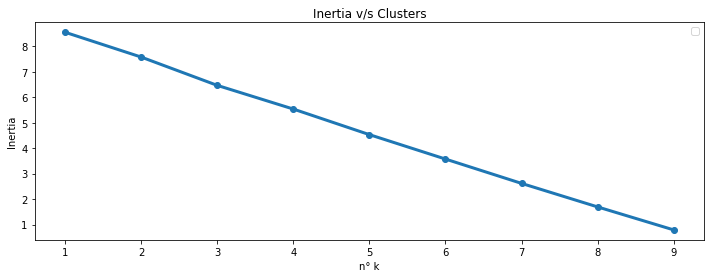

In [8]:
# plot inertia values

#import matplotlib.pyplot as plt

f, (ax) = plt.subplots(figsize = (12,4))
ax.plot(num_k, inertia, '-o', linewidth = 3)
ax.set_xlabel('n° k')
ax.set_ylabel('Inertia')
ax.title.set_text('Inertia v/s Clusters')
ax.legend()

Observando el gráfico, se definen <b> NUMERO </b> de clusters, ya que desde este valor en adelante, la tasa de disminución es menor que la anterior.

In [9]:
# N° of clusters
k_k_means = 3

In [10]:
# Train model

# Set model
model = KMeans(n_clusters = k_k_means, init = 'k-means++', max_iter = 10, n_init = 10)

# Fit model
model.fit(news_vector_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Top Words per Topic: 

centroid 0: 
 
 oficial  ,  as  ,  deber  ,  detenido  ,  joven  ,  policial  ,  grupo  ,  opinion  ,  iniciar  ,  recomendar  ,  sesión  ,  personal  ,  violencia  ,  noche  ,  jueves 

centroid 1: 
 
 violencia  ,  barcelona  ,  mundo  ,  social  ,  situación  ,  cerro  ,  izquierdo  ,  newsletter  ,  chile  ,  ciudad  ,  redar  ,  rechazar  ,  atentar  ,  messi  ,  recibir 

centroid 2: 
 
 mujer  ,  artículo  ,  ley  ,  violencia  ,  código  ,  penal  ,  penar  ,  denunciar  ,  presentar  ,  legal  ,  parejo  ,  causar  ,  nuevamente  ,  agresión  ,  sernameg 



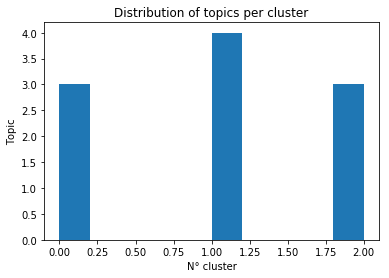

In [17]:
# Display top words

# Get order centroids
order_centroids = model.cluster_centers_.argsort()[:,::-1]

n_top_words = 15

print('Top Words per Topic: \n')

# Get principal words of each centroid
for i in range(0,k_k_means):
    
    centroid_words = np.array(news_vector_features)[order_centroids[i, 0:n_top_words]]
    
    print('centroid {0}: \n \n {1} \n'.format(i, '  ,  '.join(centroid_words)))

# Ploting results
labels = model.predict(news_vector_tfidf)

fig, ax = plt.subplots()

# TFIDF
#ax.scatter(range(labels.shape[0]),labels,c=labels)
ax.hist(labels)
ax.set_ylabel('Topic')
ax.set_xlabel('N° cluster')
ax.title.set_text('Distribution of topics per cluster')

Desde los tops words obtenidos por cada cluster, se puede inferir los siguientes tópicos asociados a cada cluster:

1) TÓPICO


### Representación vectorial de documentos utilizando Count Vectorizer

In [18]:
# Vectorizacion de textos usando Count vectorizer

# from sklearn.feature_extraction.text import CountVectorizer
# Vector representation of news
count_vectorizer = CountVectorizer(tokenizer = own_tokenizer, stop_words = stop_words, ngram_range = (1,1))

# Count vectorizer
news_vector_count = count_vectorizer.fit_transform(news['news'])

# Get features names
news_vector_features = count_vectorizer.get_feature_names()

/home/leo/Escritorio/magister_uach/env/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['litro'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Implementación modelo LDA utilizando Inferencia Variacional 

Topic number 1 

Topic number 2 

Topic number 3 

Topic number 4 

Topic number 5 

Topic number 6 

Topic number 7 

Topic number 8 

Topic number 9 



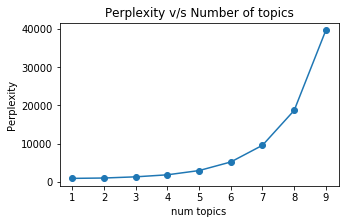

In [22]:
# find optimal number of topics

#from sklearn.decomposition import LatentDirichletAllocation
#import matplotlib.pyplot as plt

# Perplexity list
perp = []

# number of topics
num_topic = range(1,10)

# Iter over each value of topic
for topic in num_topic:
    
    print('Topic number {0} \n'.format(topic))
    
    # Define lda model
    lda = LatentDirichletAllocation(n_components = topic, max_iter = 10,
      learning_method = 'online',
      learning_offset = 50,
      random_state = 0)
    
    # Fit model
    lda.fit(news_vector_count)
    
    # add perplexity
    perp.append(lda.perplexity(news_vector_count))
    
# Plot all k values
fig2, ax = plt.subplots(figsize = (5,3))
ax.plot(num_topic, perp, '-o')
ax.set_xlabel('num topics')
ax.set_ylabel('Perplexity')
ax.title.set_text('Perplexity v/s Number of topics')

Del gráfico se tiene que se definen 6 topicos, ya que para el 7 se observa aumento mayor que tasas anteriores.

In [23]:
# Define topics
topics = 8

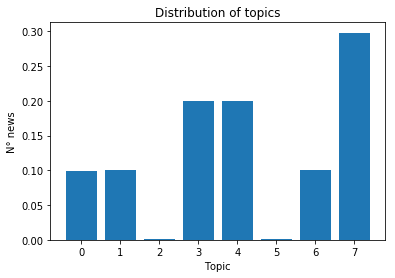

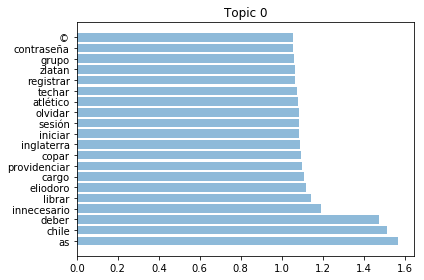

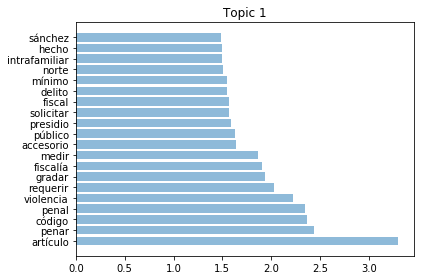

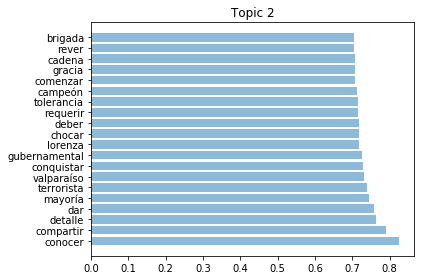

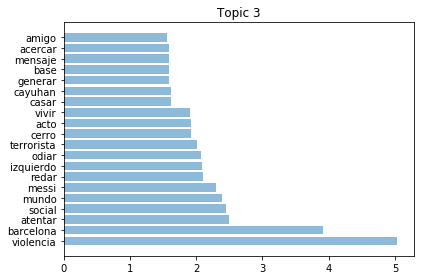

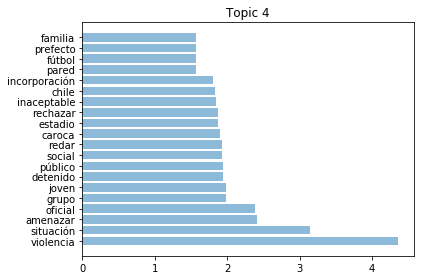

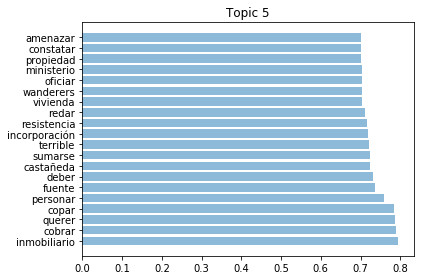

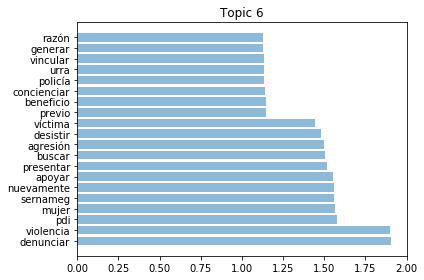

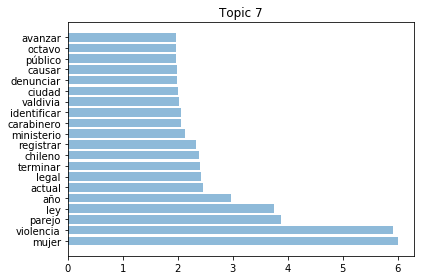

In [24]:
# Training defined model 
#Generando algunos gráficos de los resultados

lda = LatentDirichletAllocation(n_components=topics, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

# (100, 7)
topic_distribution_per_documents = lda.fit_transform(news_vector_count)

#distribución de tópicos en todos los documentos
dist_per_topic = sum(topic_distribution_per_documents)/len(news.news)

topics_array = np.arange(0,topics)

#plotting disttribution
fig, ax = plt.subplots()
ax.bar(topics_array, dist_per_topic)
ax.set_xlabel('Topic')
ax.set_ylabel('N° news')
ax.title.set_text('Distribution of topics')

#distribución de tópicos en el documento 100
#plt.bar(topics_array,height=dist_per_topic,alpha=0.5,tick_label=topics_array)
#show()

#print(lda.components_.shape)
#frecuencia de palabras por tópico
n_top_words=20
numo =np.arange(0,n_top_words)
for idx,topic in enumerate(lda.components_):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
          s.append(news_vector_features[i])
          d.append(topic[i])
    plt.figure()
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    plt.title('Topic ' + str(idx))
    plt.tight_layout()
    plt.show()


#### Respuesta a pregunta de investigación:

##### ¿Cuales son los temas mas relevantes que se expusieron en los medios durante 2017 sobre la temática violencia?

Del gráfico de distribucion de tópicos en todas los documentos, se tiene que el tópico mayoritario corresponde al tópico 3 (Violencia contra la mujer).

De las top-words de cada tópico, se logra indentificar los siguientes temas:

- Topic 0: Donald Trump - Incidente marcha en USA (supremacistas).
- Topic 1: No se identifica claramente
- Topic 2: Violencia en reality (Última Tentación, Oriana).
- Topic 3: Violencia contra la mujer
- Topic 4: Suscripción al medio
- Topic 5: Fútbol (no habla necesariamente de violencia).
- Topic 6: Final de teleserie Amanda
- Topic 7: Violencia Mapuche

### Respuesta a pregunta de Investigación

##### ¿De qué temas relacionados a la violencia hablan los 5 medios con más noticias en Chile?

In [30]:
# Name to topic
topic_name = ['Donald Trump - Incidente marcha en USA (supremacistas)',
             'No se identifica claramente',
              'Violencia en reality (Última Tentación, Oriana',
              'Violencia contra la mujer',
              'Suscripción al medio',
              ' Fútbol',
              'Final de teleserie Amanda',
              'Violencia Mapuche'
             ]

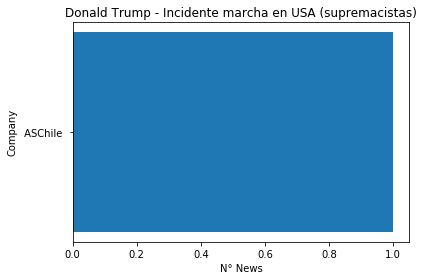

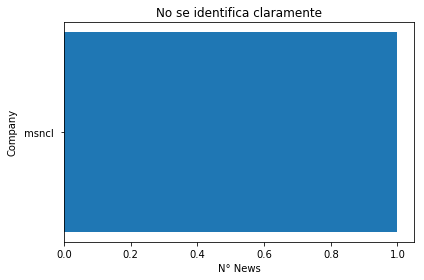

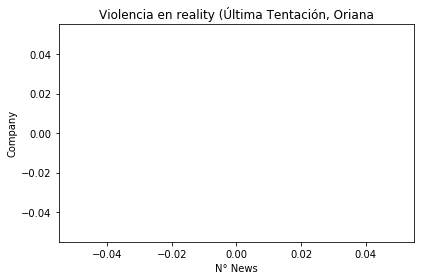

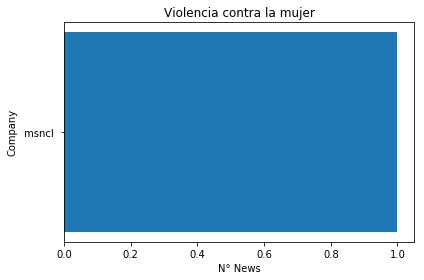

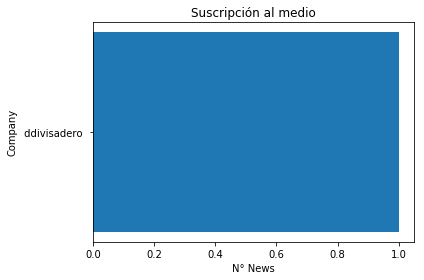

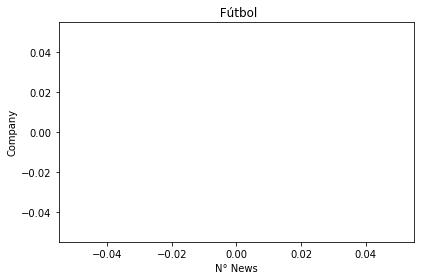

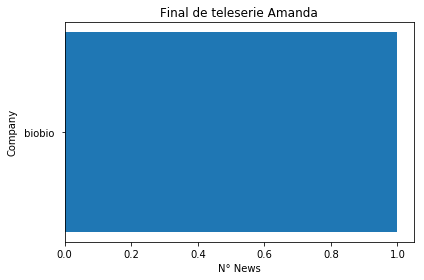

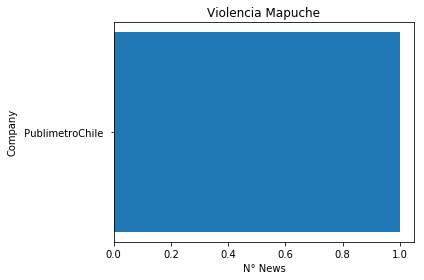

In [31]:
# Assign to each document the most frecuent topic
z=[]
for i in range(len(news.news)):
    z.append(np.argmax(topic_distribution_per_documents[i]))

# add a new variable to dataframe
news['topic'] = z

# iterate over each topic
for topic_num in range(0,topics):
    
    companies_per_topic = news[(news['company'].isin(top_20_companies)) & (news['topic'] == topic_num)].groupby('company').count().sort_values(['news'], ascending=False)
    plt.figure()
    plt.barh(y = companies_per_topic.index.values, width = companies_per_topic.news)
    plt.xlabel('N° News')
    plt.ylabel('Company')
    plt.title(str(topic_name[topic_num]))
    plt.tight_layout()


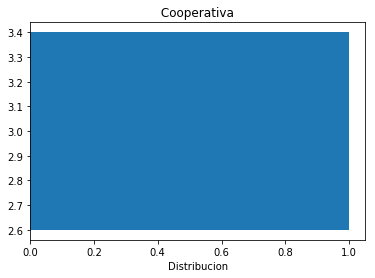

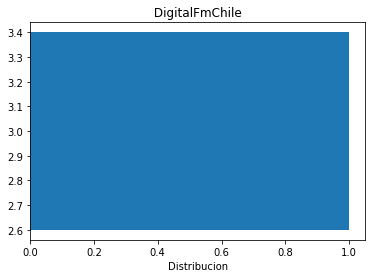

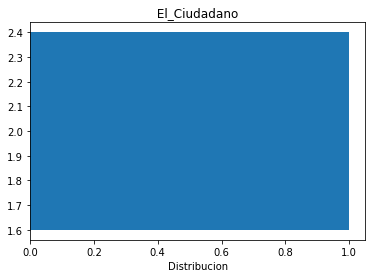

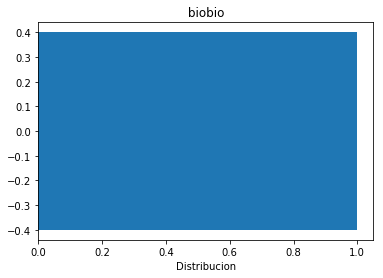

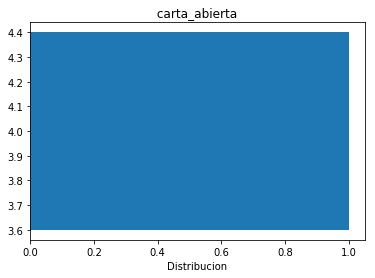

In [13]:
# Print distribution per medium

# for idx, medium in top_20_companies:
for num, medium in enumerate(top_20_companies):
    
    asd = news[(news['company'].isin(top_20_companies)) & (news.company == medium)].groupby('topic').count()
    
    plt.figure()
    
    plt.barh(y = asd.index.values, width = asd.news)
    
    plt.xlabel('Distribucion')
    
    plt.title(medium)

##### Conclusiones respecto a resultados obtenidos

Se obtienen tópicos con topwords que logran identificar y diferenciar de forma clara el tópico de cada documento.

Respecto a los tópicos más relevantes, se concluye que para el año 2017, los temas mas relevantes para estos medios corresponden a:

- Donald Trump - Incidente marcha en USA (supremacistas).
- No se identifica claramente
- Violencia en reality (Última Tentación, Oriana).
- Violencia contra la mujer
- Suscripción al medio
- Fútbol (no habla necesariamente de violencia).
- Final de teleserie Amanda
- Violencia Mapuche
 

### Implementación modelo LDA utilizando Gibbs Sampling

In [15]:
import lda

model = lda.LDA(n_topics = topics, n_iter=5000, alpha=0.1, eta=0.1, random_state=3)
model.fit(news_vector_count)  # model.fit_transform(X) is also available

topic_word = model.topic_word_  # model.components_ also works

n_top_words=10

for i, topic_dist in enumerate(topic_word):
    
    topic_words = np.array(news_vector_features)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

INFO:lda:n_documents: 10
INFO:lda:vocab_size: 725
INFO:lda:n_words: 1275
INFO:lda:n_topics: 8
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -11839
INFO:lda:<10> log likelihood: -9728
INFO:lda:<20> log likelihood: -9413
INFO:lda:<30> log likelihood: -9325
INFO:lda:<40> log likelihood: -9200
INFO:lda:<50> log likelihood: -9163
INFO:lda:<60> log likelihood: -9129
INFO:lda:<70> log likelihood: -9168
INFO:lda:<80> log likelihood: -9121
INFO:lda:<90> log likelihood: -9083
INFO:lda:<100> log likelihood: -9064
INFO:lda:<110> log likelihood: -9125
INFO:lda:<120> log likelihood: -9109
INFO:lda:<130> log likelihood: -9099
INFO:lda:<140> log likelihood: -9213
INFO:lda:<150> log likelihood: -9165
INFO:lda:<160> log likelihood: -9056
INFO:lda:<170> log likelihood: -9246
INFO:lda:<180> log likelihood: -9222
INFO:lda:<190> log likelihood: -9190
INFO:lda:<200> log likelihood: -9152
INFO:lda:<210> log likelihood: -9200
INFO:lda:<220> log likelihood: -9178
INFO:lda:<230> log likelihood: -9218
INFO:l

Topic 0: violencia joven recibir noticiar marchar querer publicar presentar sv síguenos
Topic 1: ataque conflicto quemar bio violento terrorismo policial policía sánchez marchar
Topic 2: recibir newsletter ciudad regional condicionar farox mundo correo soychile.cl suceder
Topic 3: víctima caso carabinero atención intrafamiliar jornada año denunciar femicidio bio
Topic 4: violencia delito hecho zona carabinero chile constante encontrar afectar región
Topic 5: denunciar henríquez valentino público castaldi facebook camilo cantante teta tea
Topic 6: violencia mujer ministerio comparsa armar expareja caso foto apoyar interior
Topic 7: parejo comentario país contener centrar machista entregar asesinato caso santiago


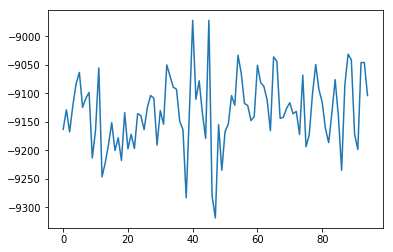

In [16]:
plt.plot(model.loglikelihoods_[5:])

El algoritmo converge ya que se mantiene pendiente constante para valores superiores a 300.

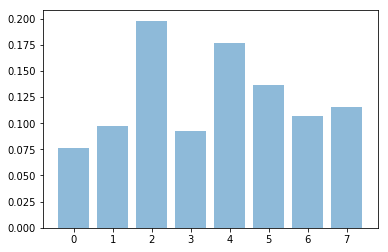

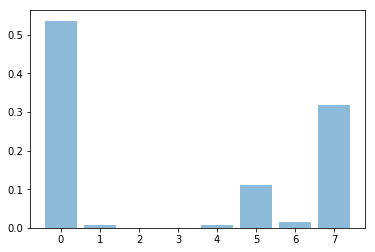

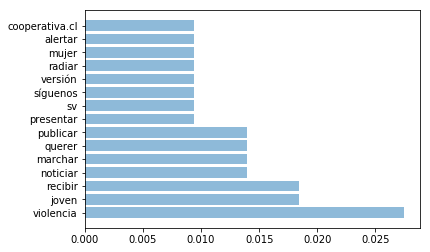

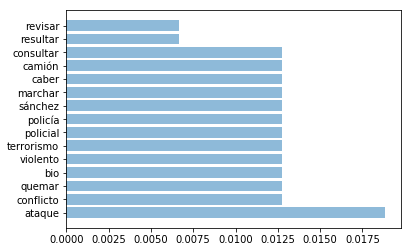

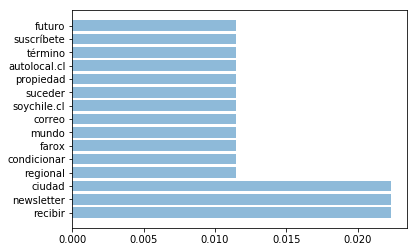

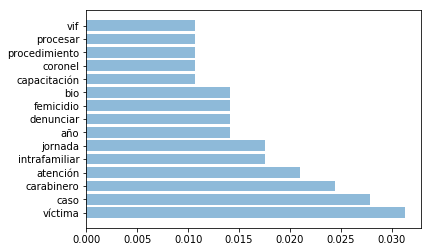

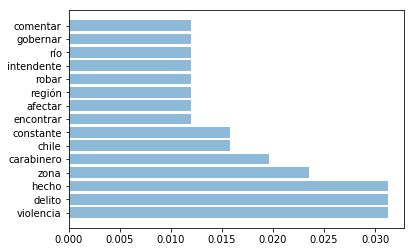

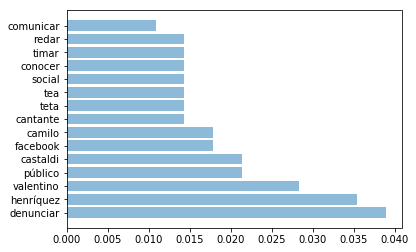

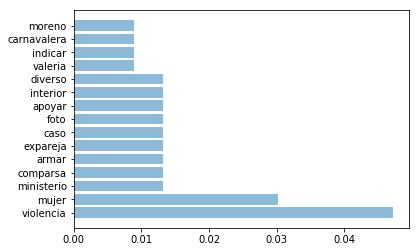

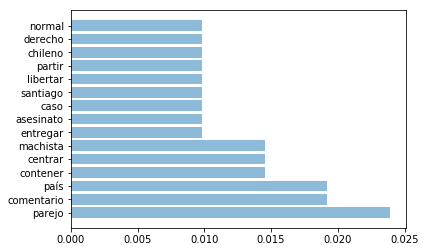

In [22]:
#Generando algunos gráficos de los resultados
#from matplotlib.pylab import hist, show

y = model.doc_topic_
#distribución de tópicos en todos los documentos
dist = sum(y)/len(news.news)

w=np.arange(0,topics)

plt.bar(w,height=dist,alpha=0.5,tick_label=w)

plt.show()

#distribución de tópicos en el documento 100
plt.bar(w,height=y[0],alpha=0.5,tick_label=w)
plt.show()

#frecuencia de palabras por tópico
n_top_words=15
numo =np.arange(0,n_top_words)

for idx,topic in enumerate(model.topic_word_):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
          s.append(news_vector_features[i])
          d.append(topic[i])
    
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    plt.show()



Analizar palabras y comparar con topwords obtenidas con el LDA anterior